<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/main/notebooks/pose_rgb/pose_rbg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "main"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 158 (delta 78), reused 106 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 1.88 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Cloned https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [2]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")


Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [3]:
%pwd

'/content'

In [4]:
from src.pose_rgb.dataset import LineModPoseDataset
from src.pose_rgb.model import ResNetRotation, TranslationNet
from src.pose_rgb.pose_utils import quaternion_to_rotation_matrix, convert_rotation_to_quaternion
from src.pose_rgb.test_dataset import *
from src.pose_rgb.loss import CombinedPoseLoss
from torch.utils.data import Dataset, DataLoader
import pathlib
import torch.optim as optim
from tqdm import tqdm


In [5]:
root_dir = '/content/drive/MyDrive/Linemod_preprocessed' #Modify here for kaggle

train_dataset = LineModPoseDataset(split='train', root_dir=root_dir)
test_dataset = LineModPoseDataset(split='test', root_dir=root_dir)

#Dataloder
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

 Loaded LineModPoseDataset
   Split: train
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3631
 Loaded LineModPoseDataset
   Split: test
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


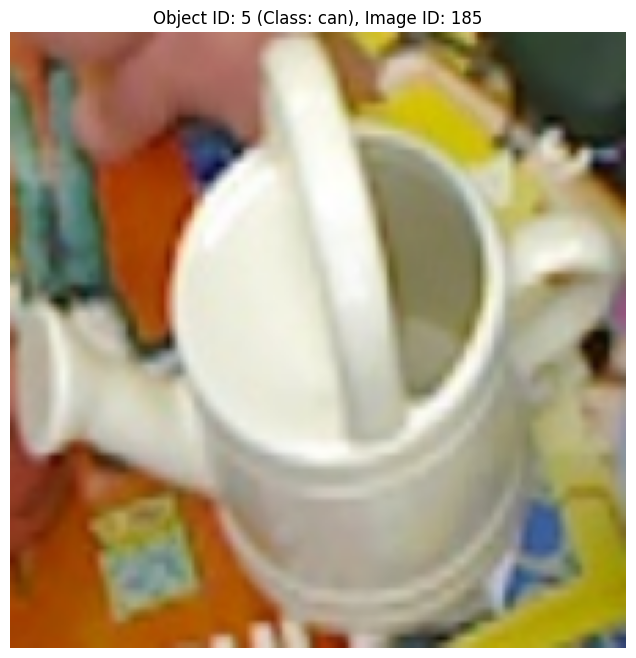


--- Posa 6D per Campione Casuale (ID Oggetto: 5) ---
  Rotazione (Quaternione w,x,y,z): [ 0.13156508  0.75069636  0.6033515  -0.2347607 ]
  Traslazione (mm) (tx,ty,tz): [111.64811    -0.9812226 930.55646  ]
  Classe Oggetto: can


In [6]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def display_random_sample_with_pose(dataset):
    """
    Prende un campione casuale dal dataset, visualizza l'immagine
    e stampa le informazioni sulla posa 6D (rotazione e traslazione).

    Args:
        dataset: L'istanza del LineModPoseDataset da cui estrarre il campione.
    """
    # Scegli un indice casuale
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]

    # Estrai i dati dal campione
    img_tensor = sample['image']
    rotation_quat = sample['rotation'].numpy() # Quaternion (w, x, y, z)
    translation_vec = sample['translation'].numpy() # Translation (tx, ty, tz)
    object_id = sample['object_id']
    class_idx = sample['class_idx']
    img_id = sample['img_id']

    # Denormalizza l'immagine per la visualizzazione
    # I valori di mean e std sono quelli usati per la normalizzazione di ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denormalized_img = img_tensor * std + mean

    # Converti in numpy e riorganizza le dimensioni da (C, H, W) a (H, W, C) per matplotlib
    img_np = denormalized_img.permute(1, 2, 0).numpy()

    # Assicurati che i valori siano nel range [0, 1] per la visualizzazione
    img_np = np.clip(img_np, 0, 1)

    # Visualizza l'immagine
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Object ID: {object_id} (Class: {class_idx}), Image ID: {img_id}")
    plt.axis('off')
    plt.show()

    # Stampa le informazioni sulla posa
    print(f"\n--- Posa 6D per Campione Casuale (ID Oggetto: {object_id}) ---")
    print(f"  Rotazione (Quaternione w,x,y,z): {rotation_quat}")
    print(f"  Traslazione (mm) (tx,ty,tz): {translation_vec}")
    print(f"  Classe Oggetto: {class_idx}")

# Esempio di utilizzo della funzione con il train_dataset
display_random_sample_with_pose(train_dataset)

In [7]:
def backproject_pixel_to_3d(crop_center, deltas, z, cam_K):
    """
    Converte le predizioni 2D (pixel) in coordinate 3D Reali (metri/mm).

    Implementa la formula della Pinhole Camera Inversa:
    X = (u - cx_ottico) * Z / fx
    Y = (v - cy_ottico) * Z / fy

    Args:
        crop_center (Tensor): Centro del crop in pixel [cx_crop, cy_crop].
                              Shape: (Batch, 2)
        deltas (Tensor): Offset predetti [delta_x, delta_y].
                         Shape: (Batch, 2)
        z (Tensor): Profondità predetta (Z).
                    Shape: (Batch,) o (Batch, 1)
        cam_K (Tensor): Matrice Intrinseca della camera.
                        Shape: (Batch, 3, 3)

    Returns:
        Tensor: Coordinate 3D [X, Y, Z]. Shape (Batch, 3)
    """
    # 1. Calcola le coordinate pixel finali assolute (u, v) nell'immagine originale
    # u = centro_crop_x + delta_x
    # v = centro_crop_y + delta_y
    u = crop_center[:, 0] + deltas[:, 0]
    v = crop_center[:, 1] + deltas[:, 1]

    # 2. Estrai i parametri intrinseci dalla matrice K
    # K = [[fx,  0, cx],
    #      [ 0, fy, cy],
    #      [ 0,  0,  1]]
    fx = cam_K[:, 0, 0]
    fy = cam_K[:, 1, 1]
    cx_ottico = cam_K[:, 0, 2] # Centro ottico principale (di solito larghezza/2)
    cy_ottico = cam_K[:, 1, 2] # Centro ottico principale (di solito altezza/2)

    # Assicuriamoci che z abbia la shape giusta per il broadcasting
    if z.dim() == 1:
        z = z.view(-1)

    # 3. Back-Projection (Formula Inversa)
    # X = (pixel_x - centro_ottico_x) * profondità / focale_x
    X = (u - cx_ottico) * z / fx
    Y = (v - cy_ottico) * z / fy

    # 4. Stack per ottenere il vettore finale (Batch, 3)
    real_3d_coords = torch.stack([X, Y, z], dim=1)

    return real_3d_coords

In [ ]:
# Init Models
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

model_rot = ResNetRotation(freeze_backbone=True).to(DEVICE)
model_trans = TranslationNet().to(DEVICE)

# Init Optimization
criterion = CombinedPoseLoss(w_rot=1.0, w_trans=1.0).to(DEVICE)
# Optimize both networks together
optimizer = optim.Adam(
    list(model_rot.parameters()) + list(model_trans.parameters()),
    lr=LEARNING_RATE
)

print("\n🔥 STARTING TRAINING...")
for epoch in range(NUM_EPOCHS):
    model_rot.train()
    model_trans.train()

    train_loss = 0.0
    train_rot = 0.0
    train_trans = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch in pbar:
        # Move data to GPU
        imgs = batch['image'].to(DEVICE)
        bbox_info = batch['bbox_info'].to(DEVICE)      # [cx%, cy%, w%, h%]
        gt_rot = batch['rotation'].to(DEVICE)
        gt_trans_abs = batch['translation'].to(DEVICE) # Absolute T
        cam_K = batch['cam_K'].to(DEVICE)
        bbox_centers = batch['bbox_center'].to(DEVICE) # Pixel centers

        # 1. Forward Pass
        pred_rot = model_rot(imgs)
        pred_trans = model_trans(imgs, bbox_info)

        pred_deltas = pred_trans[:, :2]
        pred_z = pred_trans[:, 2]

        pred_3d_real = backproject_pixel_to_3d(crop_center=bbox_centers, deltas=pred_deltas, z=pred_z, cam_K=cam_K)

        # 3. Compute Loss
        loss, l_r, l_t = criterion(pred_rot, gt_rot, pred_3d_real, gt_trans_abs)

        # 4. Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_rot += l_r.item()
        train_trans += l_t.item()
        pbar.set_postfix({'Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # --- EVALUATION PHASE ---
    model_rot.eval()
    model_trans.eval()

    val_loss = 0.0
    val_rot = 0.0
    val_trans = 0.0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Eval]"):
            imgs = batch['image'].to(DEVICE)
            bbox_info = batch['bbox_info'].to(DEVICE)
            gt_rot = batch['rotation'].to(DEVICE)
            gt_trans_abs = batch['translation'].to(DEVICE)
            cam_K = batch['cam_K'].to(DEVICE)
            bbox_centers = batch['bbox_center'].to(DEVICE)

            # Forward (OnlyPrediction)
            pred_rot = model_rot(imgs)
            pred_trans = model_trans(imgs, bbox_info)
            target_trans = backproject_pixel_to_3d(gt_trans_abs, cam_K, bbox_centers)

            # Loss Calculation
            loss, l_r, l_t = criterion(pred_rot, gt_rot, pred_trans, target_trans)

            val_loss += loss.item()
            val_rot += l_r.item()
            val_trans += l_t.item()

    avg_val_loss = val_loss / len(test_loader)

    # --- LOGGING & SAVING ---
    print(f"\n📊 Epoch {epoch+1} Report:")
    print(f"   Train Loss: {avg_train_loss:.4f} (Rot: {train_rot/len(train_loader):.4f}, Trans: {train_trans/len(train_loader):.4f})")
    print(f"   Val Loss:   {avg_val_loss:.4f}   (Rot: {val_rot/len(test_loader):.4f},   Trans: {val_trans/len(test_loader):.4f})")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_loss': best_val_loss
        }, save_path)
        print(f"🏆 New Best Model Saved! (Loss: {best_val_loss:.4f})")

    # Save a periodic checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
        }, os.path.join(CHECKPOINT_DIR, f"checkpoint_ep{epoch+1}.pth"))

print("🎉 TRAINING & EVALUATION COMPLETE!")

🔒 ResNet backbone frozen.

🔥 STARTING TRAINING...


Epoch 1/50:  16%|█▌        | 18/114 [00:59<03:46,  2.36s/it, Loss=359]

In [ ]:
# Save training history plot
import matplotlib.pyplot as plt
import json

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(run_dir, 'training_history.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Final train loss: {train_losses[-1]:.6f}")
print(f"   Final val loss: {val_losses[-1]:.6f}")

# Save training history to JSON
history = {
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses],
    'best_epoch': int(best_epoch),
    'best_val_loss': float(best_val_loss),
    'total_epochs': len(train_losses),
    'timestamp': timestamp
}

history_path = os.path.join(run_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n💾 Training history saved to: {history_path}")
print(f"📈 Plot saved to: {plot_path}")
